In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from skimage import io
import time
import os
import copy
import shutil
from bs4 import BeautifulSoup
import base64
from io import BytesIO
from PIL import Image
import requests
import asyncio
import aiohttp
from aiohttp import ClientSession, ClientConnectorError

print('to ' + torch.__version__)
print('tov ' + torchvision.__version__)

plt.ion()   # interactive mode

to 1.6.0a0+9907a3e
tov 0.7.0a0


In [65]:
def isBase64Image(text):
    return isinstance(text, str) and text.startswith('data:image/jpeg;base64')

def isUrlImage(text):
    return isinstance(text, str) and text.startswith('http')

def get_base64_content(initial):
    r1 = initial.split('data:image/jpeg;base64,')[1]
    return r1

def get_image_type(src):
    if src == None:
        return {'ext': None, 'label': None}
    if 'jpeg' in src:
        return {'ext': 'jpg', 'label': 'JPEG'}
    elif src.startswith('https://'):
        return {'ext': 'img', 'label': None}
#     else if 'png' in src:
#         return {'ext': 'png', 'label': 'PNG'}
    else:
        return {'ext': None, 'label': None}

def get_class_name_from_file(file_name: str):
    (class_name, ext) = file_name.split('.html')
    return class_name

def get_data_dir():
    return os.path.join(os.getcwd(), 'data', 'vespa_mandarinia_data')

def get_sample_file_name(file_name):
    data_dir = get_data_dir
    return os.path.join(data_dir, file_name)
    
async def seed_images():
    print('Seeding...')
    data_dir = get_data_dir()
    if os.path.exists(data_dir):
        shutil.rmtree(data_dir)
    os.mkdir(data_dir)
    await process_html_files()
    print('Seeding complete')

    
async def stream_to_data(stream):
    empty_bytes = b''
    result = empty_bytes
    while True:
        chunk = await stream.read(8)
        if chunk == empty_bytes:
            break
        result += chunk
    return result
    
async def make_file_from_base64(src_string: str, file_name: str):
    image_type = get_image_type(src_string)
    content = get_base64_content(src_string)
    decoded = base64.b64decode(content)
    bytes_data = BytesIO(decoded)
    image = Image.open(bytes_data)
    ext = image_type.get('ext')
    file_path = f'{file_name}.{ext}'
    image.save(file_path, image_type['label'])
    
async def make_file_from_url(url: str, file_name: str, session: ClientSession):
    try:
        resp = await session.request(method="GET", url=url)
        image_contents = await stream_to_data(resp.content)
        image = Image.open(BytesIO(image_contents))
        # TODO: handle other image types
        if image.format == 'JPEG':
            image.save(file_name + '.jpg', image.format)
    except ClientConnectorError:
        print('Error getting image: ', url)
        
async def make_requests(items, **kwargs) -> None:
    base64_tasks = []
    url_tasks = []

    for item in items:
        if item['request_type'] == 'base64':
            handler = make_file_from_base64(item['src'], item['file_name'])
            base64_tasks.append(handler)
        elif item['request_type'] == 'url':
            url_tasks.append(item)
      
    base64_results = await asyncio.gather(*base64_tasks)

    async with ClientSession() as session:
        tasks = []
        for item in url_tasks:
            tasks.append(
                make_file_from_url(item['src'], item['file_name'], session=session)
            )
        results = await asyncio.gather(*tasks)
        return results

async def process_html_files():
    all_items = []
    files = ['vespa_mandarinia', 'sphex_ichneumoneus', 'sphecius_speciosus']
    for file in files:
        # use file name same as class_name
        class_name = file
        dir_path = os.path.join(get_data_dir(), class_name)
        # os.mkdir(dir_path)
        path = os.path.join('data', 'html', f'{file}.txt')
        items = process_html_file(path, class_name)
        all_items.append(items)
    # Flatten list
    all_items = [ item for item_group in all_items for item in item_group ]
    print('Attempting to create {} images'.format(len(all_items)))
    next_items = []
    count = 0
    for item in all_items:
        class_name = item['class_name']
        file_name = os.path.join(get_data_dir(), f"{class_name}-{count}")
        # file_name = os.path.join(get_data_dir(), class_name, f"{class_name}-{count}")
        next_items.append({**item, 'file_name': file_name})
            
        count += 1
            
    results = await make_requests(next_items)
                        
    

def process_html_file(file_name: str, class_name: str):
    with open(file_name, 'r') as file:
        soup = BeautifulSoup(file.read(), 'html.parser')

    el = soup.find(id="islrg")
    images = el.find_all('img')
    items = []

    for image in images:
        request_type = None
        if (isBase64Image(image.get('src'))):
            request_type = 'base64'
        elif isUrlImage(image.get('src')):
            request_type = 'url'
        item = {
            "src": image.get('src'),
            "alt": image.get('alt'),
            'class_name': class_name,
            "request_type": request_type
        }
        if item['request_type'] != None:
            items.append(item)
    return items


In [11]:
# Seed data
await seed_images()

Seeding...
Attempting to create 1384 images
Seeding complete


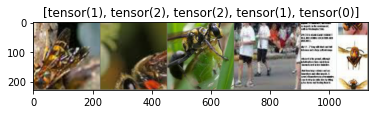

In [89]:
class_names_2 = ['vespa_mandarinia', 'sphecius_speciosus', 'sphex_ichneumoneus']

class PrimaryDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        #self.images = os.listdir(root_dir)
        self.images = [file for file in os.listdir(root_dir) if file.endswith('jpg')]
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]


class DerivedDataset(Dataset):
    def __init__(self, subset, root_dir, transform=None):
        self.subset = subset
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
        
    def image_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index):
        file_name = self.subset[index]
        class_name = file_name.split('-')[0]
        class_index = class_names_2.index(class_name)
        file_path = os.path.join(self.root_dir, file_name)
        image = self.image_loader(file_path)
        if self.transform:
            image = self.transform(image)
        return (image, class_index)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

validation_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = PrimaryDataset(get_data_dir())
full_dataset_size = len(full_dataset)
train_size = int(0.8 * full_dataset_size)
validation_size = full_dataset_size - train_size

train_subset, validation_subset = torch.utils.data.random_split(
    full_dataset,
    [train_size, validation_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset = DerivedDataset(train_subset, get_data_dir(), train_transform)
validation_dataset = DerivedDataset(validation_subset, get_data_dir(), validation_transform)

train_dataloader = DataLoader(train_dataset, batch_size=5)
validation_dataloader = DataLoader(validation_dataset, batch_size=5)

# for i, data in enumerate(train_loader):
#     image, class_name, file_name = data
#     print(file_name)
#     if i > 50: break
# print()
# print()
# for i, data in enumerate(validation_loader):
#     image, class_name, file_name = data
#     print(file_name)
#     if i > 50: break

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title[0:10])
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, class_names = next(iter(train_dataloader))
inputs, class_names = next(iter(train_dataloader))
# print('class_names', class_names)
# print('file_names', file_names)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in range(len(class_names))])

In [92]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    start_time = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
                dataset = train_dataset
            else:
                model.eval()
                dataloader = validation_dataloader
                dataset = validation_dataset
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloader:
#                 print('inputs', inputs)
#                 print('labels', labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward pass
                # track history only if training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward and optimize only if training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            
            epoch_loss = running_loss / len(dataset)
            # TODO: why call double() here?
            epoch_acc = running_corrects.double() / len(dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'validation' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_accuracy))
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model

In [94]:
# Load pretrained model
model = models.resnet18(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Freeze conv net parameters (we are using conv net of pretrained resnet18 as fixed feature extractor)
for param in model.parameters():
    param.requires_grad = False
    
num_features = model.fc.in_features
# Replace fully connected layer
# TODO: use dynamic len(class_names) instead of hard-coded value of 3
model.fc = nn.Linear(num_features, 3)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

result = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/10
----------
train Loss: 1.0602 Acc: 0.4986
validation Loss: 0.7659 Acc: 0.6703

Epoch 1/10
----------
train Loss: 0.9534 Acc: 0.6049
validation Loss: 0.7520 Acc: 0.6920

Epoch 2/10
----------
train Loss: 0.9923 Acc: 0.5840
validation Loss: 0.9526 Acc: 0.6522

Epoch 3/10
----------
train Loss: 0.9741 Acc: 0.6158
validation Loss: 0.8737 Acc: 0.6558

Epoch 4/10
----------
train Loss: 0.9667 Acc: 0.6249
validation Loss: 0.9389 Acc: 0.6413

Epoch 5/10
----------
train Loss: 0.9490 Acc: 0.6113
validation Loss: 0.8107 Acc: 0.6739

Epoch 6/10
----------
train Loss: 0.9699 Acc: 0.6249
validation Loss: 0.7939 Acc: 0.6848

Epoch 7/10
----------
train Loss: 0.7205 Acc: 0.6885
validation Loss: 0.6800 Acc: 0.7246

Epoch 8/10
----------
train Loss: 0.7278 Acc: 0.6921
validation Loss: 0.6648 Acc: 0.7174

Epoch 9/10
----------
train Loss: 0.7186 Acc: 0.6912
validation Loss: 0.7036 Acc: 0.7101

Training complete in 0m 52s
Best val accuracy: 0.724638


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/vespa_mandarinia'

image_datasets = []
dataloaders = []
dataset_sizes = []
for x in ['train', 'val']:
    image_datasets.push({x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])})
    dataloaders.append({x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)})
    dataset_sizes.append({x: len(image_datasets[x])})

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")